Working Directory has been set to `/data/sknabel/autoz_lens_model`
Lens and source redshifts at [0.32517549] and [0.43264818].
Einstein radius prior: 0.5183335636447157
1.973319 0.0493245


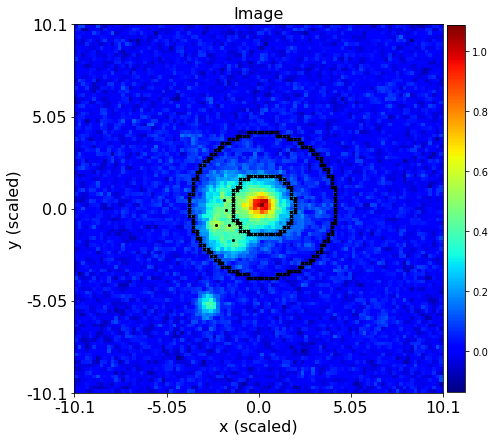

In [8]:
# Quick look at the positions to make sure they worked right.


### libraries
#et_ipython().run_line_magic('matplotlib', 'inline')
# set workspace path
from pyprojroot import here
workspace_path = str(here())#'/data/sknabel/autolens_workspace'
#get_ipython().run_line_magic('cd', '$workspace_path')
print(f"Working Directory has been set to `{workspace_path}`")

#import matplotlib.pyplot as plt
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import pandas as pd
import numpy as np
from astropy.io import fits
#from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)
#from astropy.stats import sigma_clip as clip
from os import path
import time

# set datetime variable
datetime = time.strftime("%d%m%y")

# paths
autoz_path = '/data/sknabel/autoz_lens_model/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
png_path = f'{autoz_path}visuals/png/'
pdf_path = f'{autoz_path}visuals/pdf/'


# In[4]:


# this should be constant across experiments

gama_id = 138582
links_id = 2828

# set up for input
#print('GAMA ID?')
#gama_id = int(input())
#print('LinKS ID?')
#links_id = int(input())
#print('Experiment #?')
#experiment_number = int(input())
#print('Shall we have a go?')
#input()

object_folder = f'{fits_path}G{gama_id}_{links_id}/'
output_folder = f'{autoz_path}output/G{gama_id}_{links_id}/'

# load object data table
links = pd.read_csv(f'{csv_path}/latest/links_sample_latest.csv')
lens_galaxy_data = links[links.GAMA_ID == gama_id]
zlens=lens_galaxy_data.zlens.values
zsource=lens_galaxy_data.zsource.values
einstein_radius=np.mean([lens_galaxy_data.theta_e_pm.values, lens_galaxy_data.theta_e_sis.values]) # take average of einstein radius estimates for prior
print(f'Lens and source redshifts at {zlens} and {zsource}.')
print(f'Einstein radius prior: {einstein_radius}')

# effective radius and error from DR3 sersic catalog
hdul = fits.open(f'{fits_path}SersicCatSDSS.fits')
hdul.verify('fix')
data = hdul[1].data
#print(data.columns)
#print(data.CATAID)
candidate = data[data.CATAID == gama_id]
re_r = candidate.GALRE_r[0]
re_r_err = candidate.GALREERR_r[0]
#re_g = candidate.GALRE_g[0]
#re_g_err = candidate.GALREERR_g[0]

print(re_r, re_r_err)#, re_g, re_g_err)


# In[10]:


# load r-band imaging
imaging_r = al.Imaging.from_fits(image_path=path.join(object_folder, f'{links_id}_r_image.fits'),
                              noise_map_path=path.join(object_folder, f'{links_id}_r_noise_map_image.fits'),
                              psf_path=path.join(object_folder, f'{links_id}_r_psf_image.fits'),
                               pixel_scales=0.2)

# load g-band imaging
imaging_g = al.Imaging.from_fits(image_path=path.join(object_folder, f'{links_id}_g_image.fits'),
                              noise_map_path=path.join(object_folder, f'{links_id}_g_noise_map_image.fits'),
                              psf_path=path.join(object_folder, f'{links_id}_g_psf_image.fits'),
                               pixel_scales=0.2)

# set up masks
mask = al.Mask2D.from_fits(f'{object_folder}{links_id}_g_mask.fits', pixel_scales=imaging_r.pixel_scales)
lens_mask = al.Mask2D.from_fits(f'{object_folder}{links_id}_r_lens_mask.fits', pixel_scales=imaging_r.pixel_scales)
source_mask = al.Mask2D.from_fits(f'{object_folder}{links_id}_g_source_mask.fits', pixel_scales=imaging_r.pixel_scales)

# plot subplots for first view
#print('Plotting r-band')
#imaging_plotter_r = aplt.ImagingPlotter(
#    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=mask)
#)
#imaging_plotter_r.subplot_imaging()

#print('Plotting g-band')
#imaging_plotter_g = aplt.ImagingPlotter( # this is where the noise is coming up weird
#    imaging=imaging_g, visuals_2d=aplt.Visuals2D(mask=mask)
#)
#imaging_plotter_g.subplot_imaging()

# set positions
pos = np.genfromtxt(f'{object_folder}{links_id}_g_positions_grid.csv', delimiter=',', skip_header=0)
imaging_g.positions = al.Grid2DIrregular(
    [(pos[0]), (pos[1]), (pos[2]),  (pos[3]), (pos[4]),]
)

# plot positions g-band image
#visuals_2d = aplt.Visuals2D(mask=None, positions=imaging_g.positions)
#imaging_plotter_g = aplt.ImagingPlotter(imaging=imaging_g, visuals_2d=visuals_2d)
#imaging_plotter_g.figures(image=True)

# plot lens mask r-band image
#imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
#    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=lens_mask, positions=imaging_g.positions)
#)
#imaging_plotter_r.figures(image=True)

# plot source mask g-band image
visuals_2d = aplt.Visuals2D(mask=source_mask, positions=imaging_g.positions)
imaging_plotter_g = aplt.ImagingPlotter(imaging=imaging_g, visuals_2d=visuals_2d)
imaging_plotter_g.figures(image=True)